Data setup

In [ ]:
# Functionality
import os
from glob import glob
from google.colab import files

# Basics
import numpy as np
import pandas as pd

# Visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    IS_COLAB = True
except Exception:
    IS_COLAB = False

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from numpy.random import randn

from PIL import Image
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected.")


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hitasvi","key":"9345e5983c4eea3a3e829f8719c1bb22"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000

!unzip skin-cancer-mnist-ham10000.zip


Data pre-processing


In [ ]:
base_skin_dir = "/content/"

df_meta = pd.read_csv(os.path.join(base_skin_dir,'HAM10000_metadata.csv'))
df_meta.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [ ]:
# Functionality so that we can find the image path for each metadata entry
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [ ]:
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))

tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)

tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get)

tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
4620,HAM_0005344,ISIC_0029383,nv,follow_up,45.0,male,upper extremity,/content/ham10000_images_part_2/ISIC_0029383.jpg,Melanocytic nevi,4
4348,HAM_0006798,ISIC_0024685,nv,follow_up,55.0,female,lower extremity,/content/HAM10000_images_part_1/ISIC_0024685.jpg,Melanocytic nevi,4
3246,HAM_0006216,ISIC_0030214,nv,follow_up,50.0,male,trunk,/content/ham10000_images_part_2/ISIC_0030214.jpg,Melanocytic nevi,4


In [ ]:
tile_df.describe(exclude=[np.number])

,lesion_id,image_id,dx,dx_type,sex,localization,path,cell_type
count,10015,10015,10015,10015,10015,10015,10015,10015
unique,7470,10015,7,4,3,15,10015,7
top,HAM_0003789,ISIC_0027419,nv,histo,male,back,/content/HAM10000_images_part_1/ISIC_0027419.jpg,Melanocytic nevi
freq,6,1,6705,5340,5406,2192,1,6705


<Axes: >

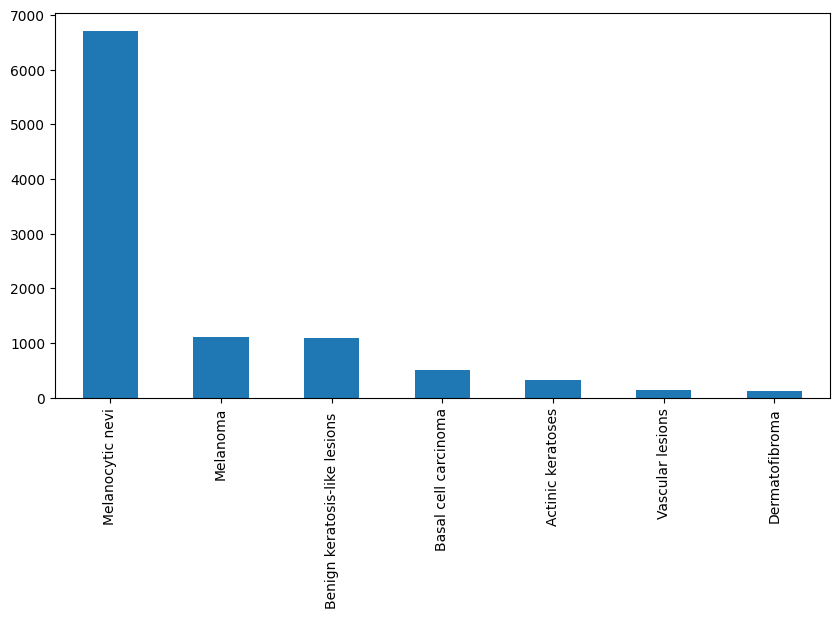

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [ ]:
categories = ['mel', 'bkl', 'bcc']
tile_df = tile_df[tile_df.dx.isin(categories)]

from skimage.io import imread
tile_df['image'] = tile_df['path'].map(imread)
# print(tile_df)

In [ ]:
# Image size distributions
tile_df['image'].map(lambda x: x.shape).value_counts()

(450, 600, 3)    2726
Name: image, dtype: int64

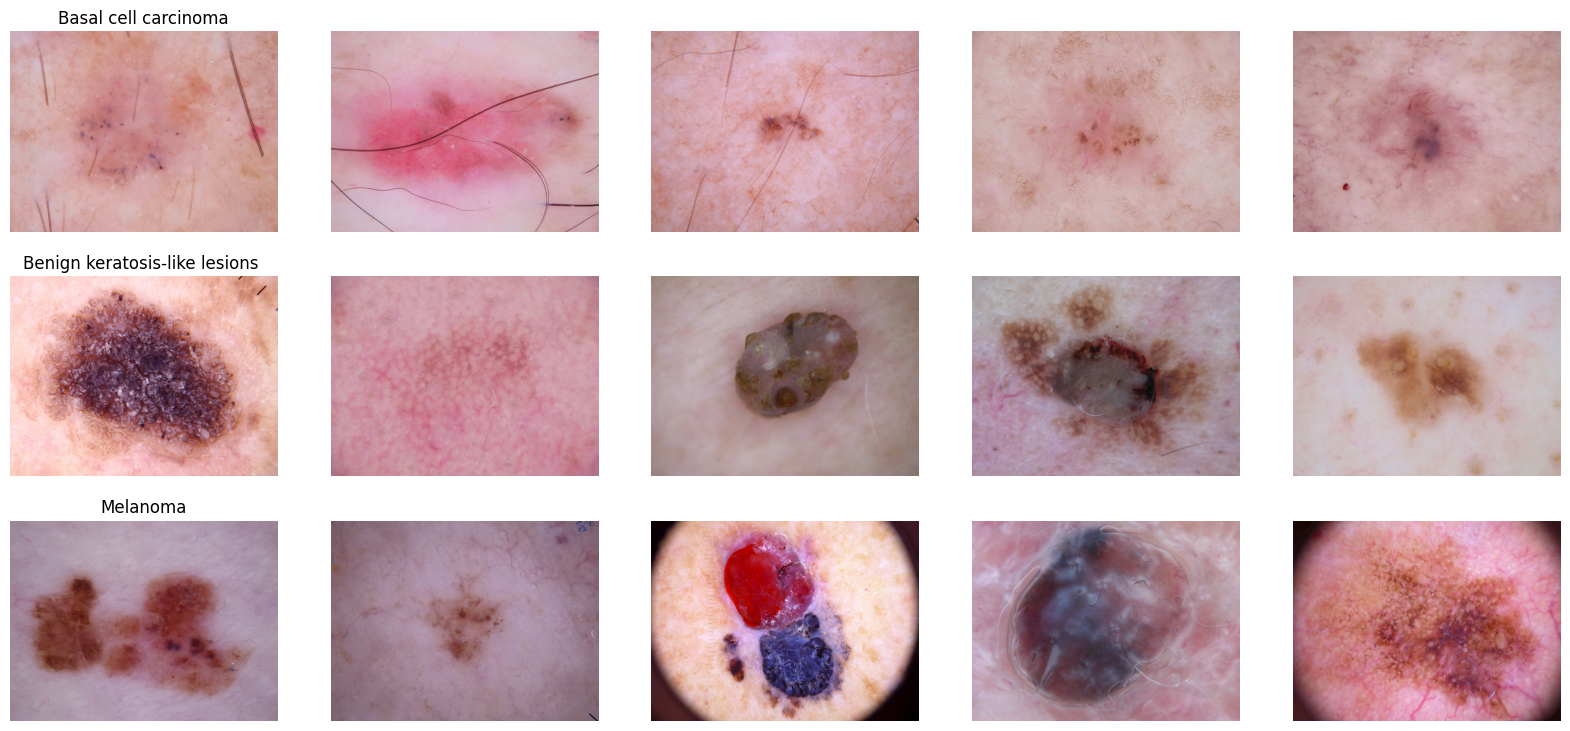

In [ ]:
n_samples = 5

fig, m_axs = plt.subplots(3, n_samples, figsize = (4*n_samples, 3*3))
for n_axs, (type_name, type_rows) in zip(m_axs,
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

GAN

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extr

<ipython-input-4-ed75d9b43894>:50: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(sample_age['age'], fit=stats.norm, color='red');


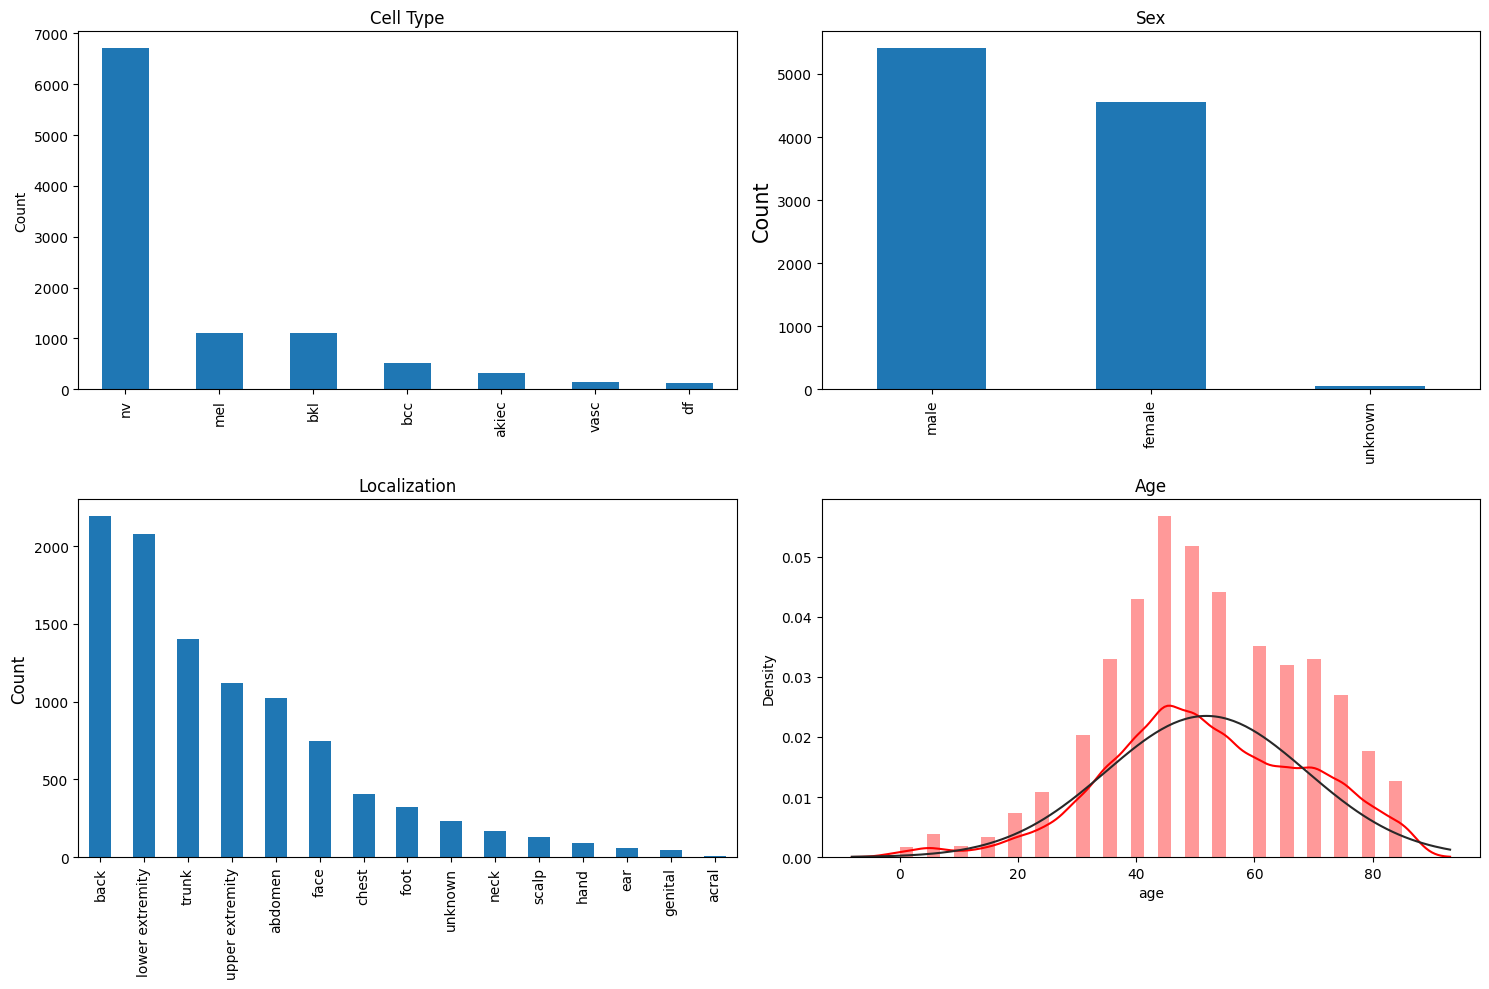

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [ ]:
np.random.seed(42)
skin_df = pd.read_csv('/content/HAM10000_metadata.csv')

SIZE=64*2

le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

skin_df['label'] = le.transform(skin_df["dx"])
print(skin_df.sample(10))

fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

print(skin_df['label'].value_counts())

# df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1] #Only BCC
# df_2 = skin_df[skin_df['label'] == 2]
# df_3 = skin_df[skin_df['label'] == 3]
# df_4 = skin_df[skin_df['label'] == 4]
# df_5 = skin_df[skin_df['label'] == 5]
# df_6 = skin_df[skin_df['label'] == 6]

In [ ]:
skin_df_balanced = pd.concat([ df_1])
print(skin_df_balanced['label'].value_counts())

image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/', '*', '*.jpg'))}
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))
# print(skin_df_balanced['path'])



1    514
Name: label, dtype: int64


In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.utils import to_categorical
X = np.asarray(skin_df_balanced['image'].tolist())
Y=skin_df_balanced['label'] #Assign label values to Y
# from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
# print(Y)
Y_cat = to_categorical(Y, num_classes=2) #Convert to categorical as this is a multiclass classification problem

trainX, testX, trainy, testy = train_test_split(X, Y_cat, test_size=0.3, random_state=42)
# print(Y_cat)
# print(trainX.shape)
# print(testX.shape)

# frames = [trainX, trainy]

train_merged = np.concatenate((trainX, testX))
# display(train_merged)

In [ ]:
for i in Y:
  if (i == 0):
    arr = X[i]
    print(skin_df_balanced['path'][i])
    break

/content/ham10000_images_part_1/ISIC_0027419.jpg


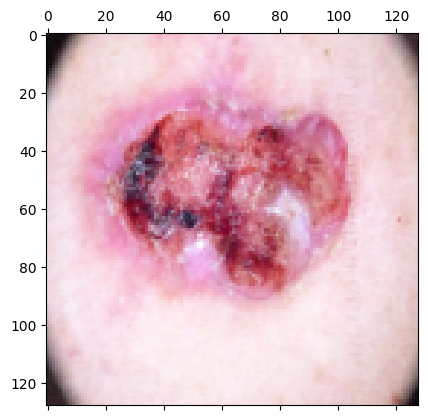

In [ ]:
plt.matshow(arr)
plt.savefig("image0.png")

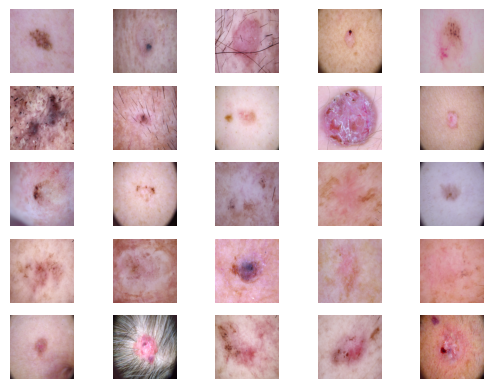

In [ ]:
for i in range(25):
	plt.subplot(5, 5, 1 + i)
	plt.axis('off')
	plt.imshow(trainX[i])
plt.show()

In [ ]:
def define_discriminator(in_shape=(128,128,3)):
	model = Sequential()
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same',input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model
test_discr = define_discriminator()
# print(test_discr.summary())

In [ ]:
def define_generator(latent_dim):
	model = Sequential()

	n_nodes = 128 * 8 * 8  #8192 nodes
	model.add(Dense(n_nodes, input_dim=latent_dim)) #Dense layer so we can work with 1D latent vector
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((8, 8, 128)))  #8x8x128 dataset from the latent vector.
	# upsample to 16x16
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #16x16x128
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 32x32
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')) #32x32x128
	model.add(LeakyReLU(alpha=0.2))

	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))#64*64*128
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))#64*64*128

	# generate
	model.add(Conv2D(3, (8,8), activation='tanh', padding='same')) #32x32x3
	return model  #Model not compiled as it is not directly trained like the discriminator.
                    #Generator is trained via GAN combined model.

test_gen = define_generator(100)
# print(test_gen.summary())

In [ ]:

def define_gan(generator, discriminator):
	discriminator.trainable = False  #Discriminator is trained separately. So set to not trainable.
	# connect generator and discriminator
	model = Sequential()
	model.add(generator)
	model.add(discriminator)
	# compile model
	opt = Adam(learning_rate=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model


In [ ]:
def load_real_samples():

	X = train_merged.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5  #Generator uses tanh activation so rescale
                           #original images to -1 to 1 to match the output of generator.
# print(X)
	return X

In [ ]:
def generate_real_samples(dataset, n_samples):
	# choose random images
	ix = randint(0, dataset.shape[0], n_samples)
	# select the random images and assign it to X
	X = dataset[ix]
	# generate class labels and assign to y
	y = ones((n_samples, 1)) #Label=1 indicating they are real
	return X, y

In [ ]:
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [ ]:
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict using generator to generate fake samples.
	X = generator.predict(x_input)
	# Class labels will be 0 as these samples are fake.
	y = zeros((n_samples, 1))  #Label=0 indicating they are fake
	return X, y

In [ ]:
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=1000, n_batch=128):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)  #the discriminator model is updated for a half batch of real samples
                            #and a half batch of fake samples, combined a single batch.
	# manually enumerate epochs and bacthes.
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):

            # Train the discriminator on real and fake images, separately (half batch each)
        #Research showed that separate training is more effective.
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
            ##train_on_batch allows you to update weights based on a collection
            #of samples you provide
            #Let us just capture loss and ignore accuracy value (2nd output below)
			d_loss_real, _ = d_model.train_on_batch(X_real, y_real)

            # generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss_fake, _ = d_model.train_on_batch(X_fake, y_fake)

			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)

            # The generator wants the discriminator to label the generated samples
        # as valid (ones)
        #This is where the generator is trying to trick discriminator into believing
        #the generated image is true (hence value of 1 for y)
			y_gan = ones((n_batch, 1))

            # Generator is part of combined model where it got directly linked with the discriminator
        # Train the generator with latent_dim as x and 1 as y.
        # Again, 1 as the output as it is adversarial and if generator did a great
        #job of folling the discriminator then the output would be 1 (true)
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # Print losses on this batch
			print('Epoch>%d, Batch %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss_real, d_loss_fake, g_loss))
	# save the generator model
	g_model.save('cifar_generator_epochs.keras')


In [ ]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = load_real_samples()
# print(dataset)
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

In [ ]:
from keras.models import load_model

model = load_model('GAN_best.keras')

num_iterations = 8
num_samples = 25

# empty DataFrame to store the generated images
A = []
for _ in range(num_iterations):

    latent_points = generate_latent_points(100, num_samples)

    X = model.predict(latent_points)

    # Scale from [-1,1] to [0,1]
    X = (X + 1) / 2.0
    X = (X * 255).astype(np.uint8)
    A.append(X)

A = np.array(A)


1/1 [==============================] - 0s 20ms/step


In [ ]:
A = A.reshape(200,128,128,3)

print(A.shape)

(200, 128, 128, 3)


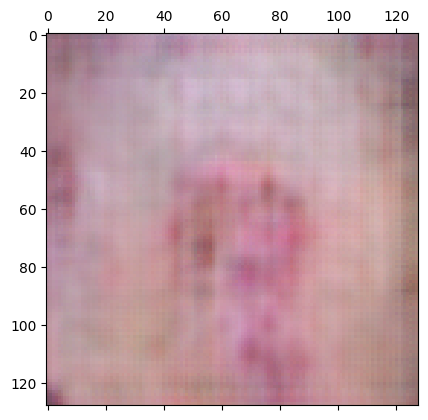

In [ ]:
plt.matshow(A[0])

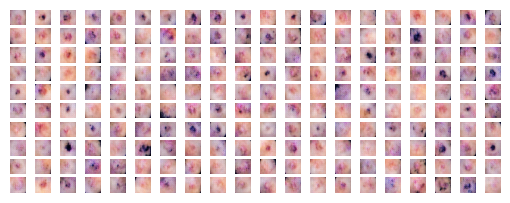

In [ ]:
for i in range(200):
	plt.subplot(20, 20, 1 + i)
	plt.axis('off')
	plt.imshow(A[i])
plt.show()

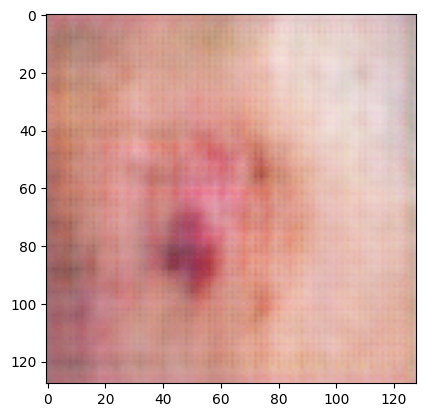

In [ ]:
plt.imshow(A[72])


In [ ]:
skin_df = pd.read_csv('/content/HAM10000_metadata.csv')

SIZE=128

# label encoding to numeric values from text
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

skin_df['label'] = le.transform(skin_df["dx"])
# print(skin_df.sample(10))

df_1 = skin_df[skin_df['label'] == 1] #bcc
df_2 = skin_df[skin_df['label'] == 2] #bkl
df_4 = skin_df[skin_df['label'] == 4] #mel

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
skin_df_balanced = pd.concat([ df_1,
                              df_2,
                              df_4])
skin_df_balanced['label'] = skin_df_balanced['label'].replace(1, 0)
skin_df_balanced['label'] = skin_df_balanced['label'].replace(2, 1)
skin_df_balanced['label'] = skin_df_balanced['label'].replace(4, 2)

In [ ]:
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/', '*', '*.jpg'))}
#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

In [ ]:
X = np.asarray(skin_df_balanced['image'].tolist())
# X = X/255.

Y=skin_df_balanced['label'] #Assign label values to Y

# print(X.shape,Y.shape)

In [ ]:
B = [0] * (A.shape[0])
B=np.array(B)
B = pd.DataFrame(B)
print(B.shape)
print(B)

(200, 1)
     0
0    0
1    0
2    0
3    0
4    0
..  ..
195  0
196  0
197  0
198  0
199  0

[200 rows x 1 columns]


In [ ]:
# A = A/255.

In [ ]:
A

array([[[[136, 109, 119],
         [137, 108, 121],
         [142, 105, 121],
         ...,
         [146, 111, 121],
         [140, 112, 124],
         [139, 113, 120]],

        [[139, 110, 121],
         [145, 109, 124],
         [144, 108, 125],
         ...,
         [140, 103, 120],
         [137, 106, 121],
         [140, 107, 117]],

        [[149, 115, 128],
         [147, 115, 129],
         [161, 116, 135],
         ...,
         [147, 104, 116],
         [145, 103, 119],
         [143, 106, 115]],

        ...,

        [[120,  82, 100],
         [125,  84, 103],
         [140,  88, 114],
         ...,
         [154, 115, 118],
         [154, 113, 115],
         [152, 111, 108]],

        [[118,  81,  98],
         [124,  82, 104],
         [140,  85, 113],
         ...,
         [159, 116, 116],
         [154, 111, 111],
         [151, 107, 107]],

        [[108,  87,  99],
         [118,  82,  92],
         [127,  83, 104],
         ...,
         [154, 111, 110],
        

In [ ]:
frames = [B, Y]
Yf = pd.concat(frames)
print(Yf)

       0
0      0
1      0
2      0
3      0
4      0
...   ..
2319   2
6769   2
8820   2
8834   2
10014  2

[2926 rows x 1 columns]


In [ ]:
Xf=np.concatenate((A,X))

In [ ]:
Xf.shape

(2926, 128, 128, 3)

In [ ]:
Yf = to_categorical(Yf, num_classes=3)
print(Xf.shape,Yf.shape)

(2926, 128, 128, 3) (2926, 3)


In [ ]:
x_train_auto, x_test_auto, y_train_auto, y_test_auto = train_test_split(Xf, Yf, test_size=0.2, random_state=42)
print(x_train_auto.shape,y_train_auto.shape)
# print(y_train_auto)

(2340, 128, 128, 3) (2340, 3)


In [ ]:
vgg=tf.keras.applications.VGG19(input_shape=(128,128,3),weights='imagenet', include_top=False)
for i in vgg.layers:
    i.trainable = False


80134624/80134624 [==============================] - 0s 0us/step


In [ ]:
model = tf.keras.models.Sequential([
    vgg,


    tf.keras.layers.Conv2D(64, (3, 3), padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(32, (3, 3), padding="same"),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation = 'softmax')
])
print(model.summary())


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 128)         589952    
                                                                 
 activation (Activation)     (None, 4, 4, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 4, 4, 128)         512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          73792     
                                                        

In [ ]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='/content/',
                                                  monitor='val_acc', mode='max',
                                                 verbose=1)


In [ ]:
model.compile(loss = 'categorical_crossentropy',
             optimizer = 'adam',
              metrics = ['accuracy'])
history = model.fit(x_train_auto,
                    y_train_auto,
                    validation_split=0.2,
                    batch_size = 64,
                    epochs = 100,
                    )#callbacks=[callback]


Epoch 1/100
30/30 [==============================] - 16s 247ms/step - loss: 1.1958 - accuracy: 0.5112 - val_loss: 1.8184 - val_accuracy: 0.4744
Epoch 2/100
30/30 [==============================] - 4s 149ms/step - loss: 0.8001 - accuracy: 0.6496 - val_loss: 1.5527 - val_accuracy: 0.5150
Epoch 3/100
30/30 [==============================] - 4s 129ms/step - loss: 0.6526 - accuracy: 0.7260 - val_loss: 1.0786 - val_accuracy: 0.5684
Epoch 4/100
30/30 [==============================] - 4s 149ms/step - loss: 0.5132 - accuracy: 0.7698 - val_loss: 0.9723 - val_accuracy: 0.5876
Epoch 5/100
30/30 [==============================] - 4s 128ms/step - loss: 0.4425 - accuracy: 0.8061 - val_loss: 0.8457 - val_accuracy: 0.6068
Epoch 6/100
30/30 [==============================] - 5s 152ms/step - loss: 0.3414 - accuracy: 0.8584 - val_loss: 0.9175 - val_accuracy: 0.6325
Epoch 7/100
30/30 [==============================] - 4s 128ms/step - loss: 0.2657 - accuracy: 0.8868 - val_loss: 0.9468 - val_accuracy: 0.636

In [ ]:
model.save("VGG.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
new_model=keras.models.load_model("VGG.h5")

In [ ]:
new_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 conv2d (Conv2D)             (None, 4, 4, 128)         589952    
                                                                 
 activation (Activation)     (None, 4, 4, 128)         0         
                                                                 
 batch_normalization (Batch  (None, 4, 4, 128)         512       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 4, 4, 128)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 64)          73792     
                                                        

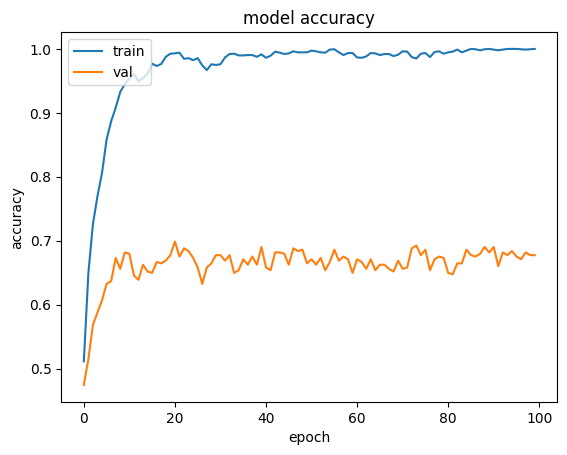

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

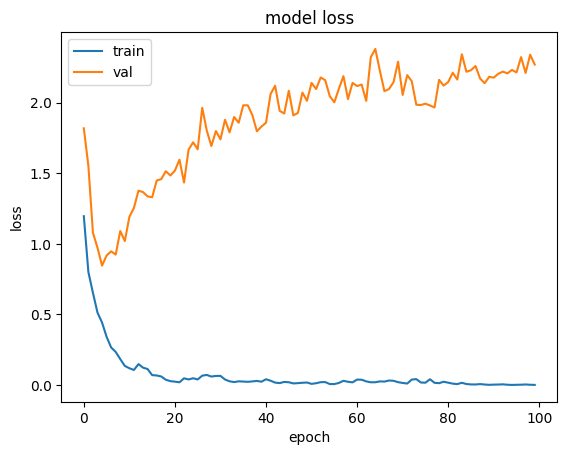

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
model.save('vgg19_best.keras')


In [ ]:
model= tf.keras.models.load_model('vgg19_best.keras')

In [ ]:
loss, acc = model.evaluate(x_test_auto, y_test_auto, verbose=2)


19/19 - 1s - loss: 2.2783 - accuracy: 0.6826 - 1s/epoch - 54ms/step


In [ ]:
import sklearn.metrics as metrics

y_pred_ohe = model.predict(x_test_auto)
y_pred_ohe = np.argmax(y_pred_ohe,axis=1)
y_pred_labels = np.argmax(y_test_auto, axis=1)

confusion_matrix = metrics.confusion_matrix(y_true=y_pred_labels, y_pred=y_pred_ohe)


19/19 [==============================] - 1s 48ms/step


In [ ]:
class_labels = ['bcc','bkl','mel']
report = sklearn.metrics.classification_report(y_pred_labels, y_pred_ohe, target_names = class_labels)
print(report)


              precision    recall  f1-score   support

         bcc       0.76      0.72      0.74       152
         bkl       0.64      0.60      0.62       216
         mel       0.67      0.73      0.70       218

    accuracy                           0.68       586
   macro avg       0.69      0.69      0.69       586
weighted avg       0.68      0.68      0.68       586



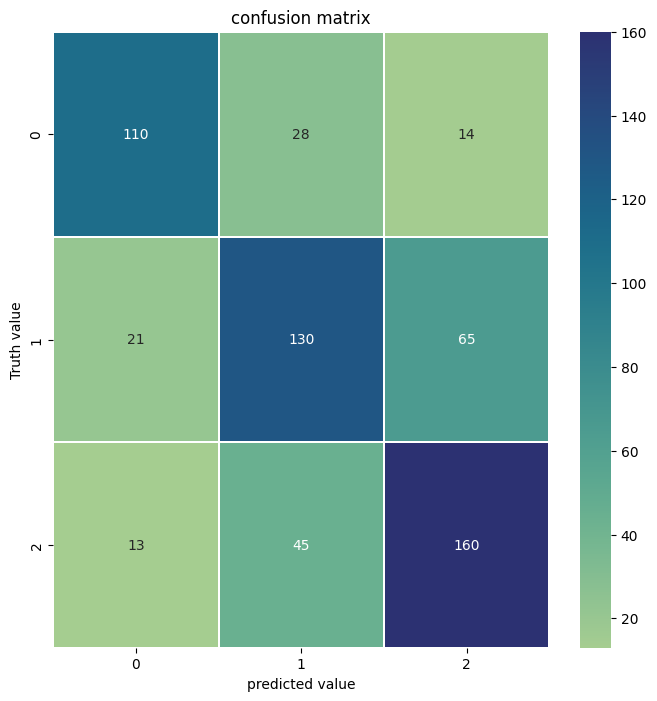

[[110  28  14]
 [ 21 130  65]
 [ 13  45 160]]


In [ ]:
cm = sklearn.metrics.confusion_matrix(y_pred_labels, y_pred_ohe)
plt.figure(figsize=(8,8))
sns.heatmap(cm, fmt='.0f', cmap="crest", annot=True, linewidths=0.2 )
plt.title('confusion matrix')
plt.xlabel('predicted value')
plt.ylabel('Truth value')
plt.show()
print(sklearn.metrics.confusion_matrix(y_pred_labels, y_pred_ohe))


In [ ]:
A[0].shape

(128, 128, 3)

In [ ]:
img = np.expand_dims(A[0], axis=0)


<function matplotlib.pyplot.show(close=None, block=None)>

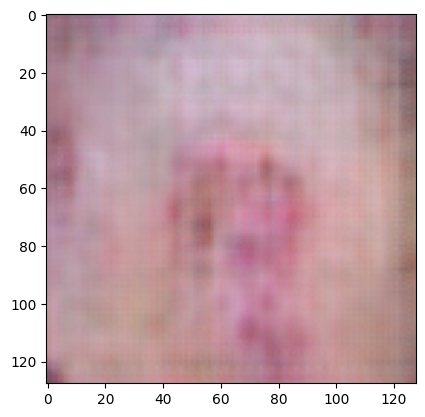

In [ ]:
plt.imshow(A[0])
plt.show

In [ ]:
predictions = model.predict(img)

1/1 [==============================] - 1s 1s/step


In [ ]:
output = np.argmax(predictions, axis=1)

In [ ]:
output

array([0])

In [ ]:
str(output)

'[0]'

In [ ]:
model.save_weights("VGG_weights.h5")

In [ ]:
model.load_weights("VGG_weights.h5")

In [ ]:
def process_image(image_path):
    img = Image.open(image_path)
    img = img.resize((128, 128))  # Resize the image to the input size expected by your CNN model
    #img = np.expand_dims(img, axis=0)
    img = np.asarray(img)
    return img

In [ ]:
processed=process_image('/content/HAM10000_images_part_1/ISIC_0024306.jpg')

In [ ]:
processed.shape

(128, 128, 3)

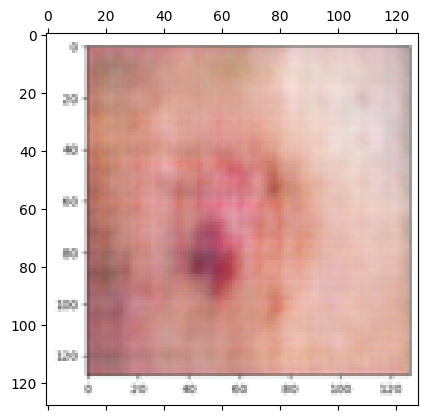

In [ ]:
plt.matshow(processed)